In [11]:
%load_ext autoreload
%autoreload 2

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import json
from random import sample

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [13]:
import torch
import torch.nn.functional as F

from transformers import *

In [14]:
models = {}

In [15]:
model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-base', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-large', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-large and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

In [21]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2-large', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

In [48]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2-xl', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

In [17]:
model, tokenizer, mask_token = models['roberta-large']

In [18]:
import re
import pandas as pd
import collections
import os
import nltk
import random

In [19]:
# 处理同义词->synonym_dict
# BATS
nltk.download('averaged_perceptron_tagger')

file_synonyms_intensity = open('synonyms_intensity.txt')
file_synonyms_exact = open('synonyms_exact.txt')

synonyms_intensity = file_synonyms_intensity.read()
synonyms_exact = file_synonyms_exact.read()

synonyms_dict = {}
files = [file_synonyms_intensity,file_synonyms_exact]

for each in files:
    # put the pos to the start of file
    each.seek(0, os.SEEK_SET)

    for line in each.read().split("\n"):
        line_split = line.split()
        master = line_split[0]
        slave = line_split[1].split('/')
        if not master in synonyms_dict:
            synonyms_dict[master] = slave
            
ordered_synonyms_dict = collections.OrderedDict(sorted(synonyms_dict.items()))
ordered_synonyms_dict
# 去掉非形容词
adj_ordered_synonyms_dict = {}
for (key,value) in ordered_synonyms_dict.items():
    if nltk.pos_tag([key])[0][1] == "JJ":
        adj_ordered_synonyms_dict[key] = value
        
adj_ordered_synonyms_dict.pop('vocabulary')
print(adj_ordered_synonyms_dict)
print('============================================')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/xd/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


{'angry': ['furious', 'enraged', 'outraged', 'aggrivated', 'irate', 'seething'], 'bad': ['awful', 'atrocious', 'abominable', 'dreadful', 'painful', 'terrible', 'unspeakable'], 'creative': ['ingenious', 'inventive', 'demiurgic', 'deviceful', 'innovational', 'innovative', 'innovatory', 'original', 'originative'], 'guilty': ['remorseful', 'sorrowful', 'unworthy'], 'happy': ['ecstatic', 'enraptured', 'rapturous', 'rapt', 'rhapsodic'], 'homogeneous': ['uniform', 'unvarying'], 'identical': ['same', 'indistinguishable'], 'necessary': ['essential', 'indispensable', 'vital', 'required'], 'new': ['modern', 'recent'], 'rational': ['logical', 'coherent', 'reasonable', 'sane'], 'reasonable': ['sensible'], 'strong': ['powerful', 'forceful', 'super', 'potent'], 'unhappy': ['miserable', 'suffering', 'wretched']}


In [24]:
# 把dict的词替换到句子模板
templates = [
    'John is * _ and Mary is also * = .',
    'The synonyms of * _ is * = .'
]

texts = []
one = templates[1]
for (key,value) in adj_ordered_synonyms_dict.items():
    for word in value:
        example = one.replace('_', key).replace('=', word)
        texts.append(example)
#print(texts[8:20])
print(len(texts))            

52


In [25]:
# 得到attention值
all_attn_probs, idx_pairs, tokenses = [], [], []
for text in tqdm(texts):
    if mask_token is not None:
        text = text.replace(' _ ', ' %s ' % mask_token)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text, add_special_tokens=True))
    tokens = ['*' if token in ['*', 'Ġ*'] else token for token in tokens]
    marker = '*'
    if marker in tokens:
        assert tokens.count(marker) == 2, str(tokens)
        p, h = [i for i, token in enumerate(tokens) if token == marker]
        tokens = [token for token in tokens if token != marker]
        h -= 1
        #print(tokens[p], tokens[h])
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    pred_idx = [i for i, token in enumerate(tokens) if token == mask_token] if mask_token is not None else [-1]
    tokens = ['@' + token if not token.startswith('Ġ') and token not in ['<s>', '</s>', '<mask>'] else token.replace('Ġ', '') 
              for token in tokens] 
    #print(tokens)
    
    input_ids = torch.tensor([token_ids])
    with torch.no_grad():
        logits, attns = model(input_ids, output_attentions=True)
        probs = F.softmax(logits, dim=-1)

    attn_scores, attn_probs = zip(*attns)
    attn_scores, attn_probs = torch.cat(attn_scores, dim=0), torch.cat(attn_probs, dim=0)
    all_attn_probs.append(attn_probs)
    idx_pairs.append((p, h))
    tokenses.append(tokens)
    #print("===============================")
   # print(tokenses)
    #print(idx_pairs)
    #print(attn_probs[0, 0, 1, 1])
   # print(attn_probs[:, :, h, p])

# 求注意力值的平均值
attn_sum = np.zeros((24, 16),dtype='float32')
i = 0
for attn_one, (p, h) in zip(all_attn_probs, idx_pairs):    
    attn_every = np.array(attn_one[:, :, h, p])
   #求和
    attn_sum += attn_every
   # 记录总共有多少句子来求平均
    i = i+1
#sum = attn_sum.tolist()
#求平均
attn_average = attn_sum/i
average = attn_average.tolist()
print(average)

100%|██████████| 52/52 [00:17<00:00,  2.89it/s]

[[0.13471880555152893, 0.1339869648218155, 0.10318085551261902, 0.15457852184772491, 0.10078512877225876, 0.15979450941085815, 0.10815597325563431, 0.1736038327217102, 0.14424508810043335, 0.07427261024713516, 0.05024821311235428, 0.02689826861023903, 0.11577755957841873, 0.14502984285354614, 0.11294712126255035, 0.08377718925476074], [0.0028600776568055153, 0.006902487017214298, 0.003042456693947315, 0.010350058786571026, 0.002260890556499362, 0.030559051781892776, 0.22864031791687012, 0.02578565664589405, 0.004084734711796045, 4.65961991213959e-12, 0.0029298653826117516, 0.030950970947742462, 0.04976977780461311, 0.001438687788322568, 2.825698857122916e-07, 0.009119637310504913], [0.12915228307247162, 0.013063536956906319, 1.2496263745997993e-10, 0.0028017719741910696, 0.15883371233940125, 1.639816412087168e-17, 0.0018598089227452874, 0.00022910612460691482, 0.0006786677404306829, 5.657180736307055e-06, 7.868071405641487e-22, 0.001441583619453013, 1.6488198874545485e-22, 2.6814109687

Text(0.5, 33.0, 'Average-synonyms-head')

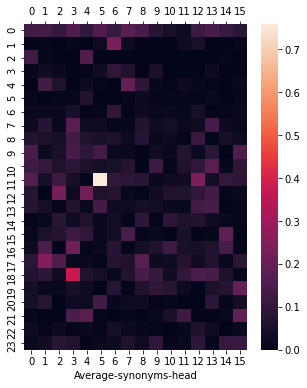

In [26]:
# 算平均后的head图
fig = plt.subplots(1,1,sharey=False, figsize=(5 , 6))
ax = sns.heatmap(attn_average)
ax.tick_params(top=True, labeltop=True)
ax.set_xlabel('Average-synonyms-head')